**Physics-Informed Neural Networks using PyTorch**

[*Pierre Kerfriden*]( https://tinyurl.com/mw4h5t7s), Mines Paris - PSL







**[Lecture slides](https://1drv.ms/b/s!AjM6vw3llOZ-j6VMnPkesFFN7sZKGQ?e=RBjEOt)**


1. **[PINNs (this notebook)](https://colab.research.google.com/drive/1IJsIHkaoskWFNFnoPYiMTbTx0cos-tNR?usp=sharing)**

2. **[Autograd demo](https://colab.research.google.com/drive/16EeBYHqydQe9UBTFVFv1wqrd1IteapMO?usp=sharing)**

3. **[Inverse problem with unknown initial and boundary conditions](https://colab.research.google.com/drive/1l_TjppcIA9WFR-Vt3nCOgZh-nAKNNsrx#scrollTo=sLh0ddRJDqwf)**

4. **[Inverse problem with unknown conductivity field](https://colab.research.google.com/drive/1a7X3LnUHkzkwMZvV3WQKloJA98nRlk96#scrollTo=bFZW7IgqHUN3&uniqifier=1)**

5. **[Neural surrogate modelling](https://colab.research.google.com/drive/1udigfjHHYfP2FToMIv70h60dUIw2xeu4)**


**Additional readings**:

- **[Convolutional Neural Networks](https://onedrive.live.com/?authkey=%21ACKCg1ApHZEr7OA&cid=7EE694E50DBF3A33&id=7EE694E50DBF3A33%21243416&parId=7EE694E50DBF3A33%21243342&o=OneUp)**
- **[2D regression with Neural Networks in Pytorch](https://colab.research.google.com/drive/1hSw43rHC6D850VXEiVlOB-Vdb9Yh7hmt?usp=sharing#scrollTo=bQCxhicQLTmB)**
- **[AI in material engineering : a-20-minutes-long primer](https://onedrive.live.com/?authkey=%21AFjKgpvMoqhLad0&cid=7EE694E50DBF3A33&id=7EE694E50DBF3A33%21237139&parId=7EE694E50DBF3A33%21236443&o=OneUp)**

**Sources & Inspiration**

https://onlinelibrary.wiley.com/doi/full/10.1002/gamm.202100006

https://github.com/jayroxis/PINNs/blob/master/Burgers%20Equation/Burgers%20Identification%20(PyTorch).ipynb

https://github.com/nanditadoloi/PINN

https://pytorch.org/tutorials/beginner/nlp/pytorch_tutorial.html#computation-graphs-and-automatic-differentiation

**Problem description**

We are interested in solving the transient heat equation
$ \displaystyle c \frac{\partial u}{\partial t} - \nabla \cdot \left( k \nabla u \right) + \beta (u-u_\text{ref}) = q(x,t)  $ subjected to

- Dirichlet boundary conditions $u(x=0,t)= B*(1-e^{-\frac{t}{T_u}}) $ and
$u(x=L,t)=0$. Here we set $B=1$ and $T_u = 10^{-1}$

- initial conditions $u(x,t=0)=0$

We further assume that

- advection term coefficients $\beta = 3$ and $u_\text{ref}=0$

- the source term $ \displaystyle q(x,t)=1$

We look for $u(x,t)$ for all $(x,t) \in \mathcal{D} =[0,L] \times [0,T]$, with $T=1$ and $L=2$. Function $u(x,t)$ is assumed to by a fully connected neural network, with sigmoid activation functions, which means that $u(x,t)$ is infinitely differentiable. At every training step, we choose a random set of points over initial time boundary $t=0$, over spatial boundary $x=0$ and $x=L$ and within the bulk of the computational domain $\mathcal{D}$. The corresponding residual of the governing equations are then summed as a loss function, and classical backpropagation is performed to compute the gradient of the loss and update the weights of the fully connected network.




**Exercise**

For now, the diffusion term is set to zero, *i.e.* the code solves the ordinary differential equation $ \displaystyle c \frac{\partial u}{\partial t} + \beta (u-u_\text{ref}) = q(x,t) $ independently at every $x$.

**A**. Implement the diffusion term using autograd. Function `f(self,x,t)` of class `forward_problem` is to be modified appropriately at this location :


```
    # ------ modify code here --------
    flux_x = 0.
    # -----------------------------
```

**B**. Add a term penalising the boundary conditions (the `1.e-10` parameter that scales term `mse_bc` in the loss defined in solve_forward() should be replaced by an appropriately selected non-vanishing value)

# Imports and plotting function

In [1]:
import torch
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def plot_forward(net,conductivity=None,heat_source=None):

    x=np.arange(0,2,0.02)
    t=np.arange(0,1,0.02)
    ms_x, ms_t = np.meshgrid(x, t)
    x_all = np.ravel(ms_x).reshape(-1,1)
    t_all = np.ravel(ms_t).reshape(-1,1)
    pt_x = Variable(torch.from_numpy(x_all).float(), requires_grad=False).to(device)
    pt_t = Variable(torch.from_numpy(t_all).float(), requires_grad=False).to(device)

    if heat_source is not None:

      pt_u = heat_source(pt_x,pt_t)
      u=pt_u.data.cpu().numpy()
      ms_u = u.reshape(ms_x.shape)

      fig = plt.figure()
      ax = fig.add_subplot(projection = '3d')

      surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
      fig.colorbar(surf, shrink=0.4, aspect=5)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('heat source q(x,t)')
      plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')

    pt_u = net(pt_x,pt_t)
    u=pt_u.data.cpu().numpy()
    ms_u = u.reshape(ms_x.shape)

    surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.4, aspect=5)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('temperature u(x,t)')
    plt.show()

    #fig = plt.figure()
    #plt.contour(ms_x,ms_t,ms_u,20)
    #plt.xlabel('x')
    #plt.ylabel('t')
    #plt.title('temperature u(x,t)')

    if conductivity is not None:
      u = conductivity( Variable(torch.from_numpy(x).float()) )

      plt.plot(x,u,'+')
      plt.xlabel('x')
      plt.ylabel('k')
      plt.title('conductivity k(x)')
      plt.show()

# Definition of heat conduction problem

In [3]:
class forward_problem:

    def __init__(self,net=None):
        if net is not None:
          self.net = net

    def heat_source(self,x,t):
        #x_t = 0.+2.0*t
        #q = 0.*x
        q = 1.0
        return q

    def advection(self,x,t,T):
        q = - 3.0 * (T-0.)
        return q

    def conductivity(self,x):
        #k = 1.0+3.0*(x>1.0)-3.5*(x>1.5)
        k = 1.0 + 0.*x
        return k

    def heat_capacity(self,x):
        c=1.
        return c

    def ic(self,x):
        ic = 0.
        return 0.

    def bc(self,x,t):
        bc = 1.0*(1.0-torch.exp(-10.*t))*(torch.exp(-5.0*x))
        return bc

    def f(self,x,t):
        u = self.net(x,t)
        # https://pytorch.org/docs/stable/generated/torch.autograd.grad.html
        u_x = torch.autograd.grad(
                u, x,
                grad_outputs=torch.ones_like(u),
                retain_graph=True,
                create_graph=True
            )[0]
        flux = -1.0*self.conductivity(x) * u_x

        # ------ modify code here --------
        flux_x = torch.autograd.grad(
                flux, x,
                grad_outputs=torch.ones_like(u),
                retain_graph=True,
                create_graph=True
            )[0]
        # -----------------------------

        u_t = torch.autograd.grad(
                u, t,
                grad_outputs=torch.ones_like(u),
                retain_graph=True,
                create_graph=True
            )[0]
        residual = self.heat_source(x,t) - self.heat_capacity(x)*u_t - flux_x + self.advection(x,t,u)
        return residual

    def f_bc(self,x,t):
        u = self.net(x,t)
        residual = u - self.bc(x,t)
        return residual

    def f_ic(self,x,t):
        u = self.net(x,t)
        residual = u - self.ic(x)
        return residual

    def solve(self,N_iter=1000):
        solve(self,N_iter)

    def plot_forward(self):
        plot_forward(self.net)

# Training function

In [4]:
def solve(problem,N_iter=1000):

    net = problem.net

    mse_cost_function = torch.nn.MSELoss() # Mean squared error
    optimizer = torch.optim.Adam(net.parameters(),lr=1.0e-2, weight_decay=1.0e-100)

    pt_x_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 1.0), requires_grad=True).to(device)
    pt_x_collocation_ic = Variable(torch.Tensor(20,1).uniform_(0.0, 2.0), requires_grad=True).to(device)
    pt_t_collocation_ic = Variable(torch.zeros_like(pt_x_collocation_ic), requires_grad=False).to(device)
    pt_x_collocation_bc = Variable(2.0*torch.randint(0,2,size=(50,1)).float(), requires_grad=True).to(device) # randint has a bizarre behaviour, needs to give high="1 above" than higher integer in the desired distribution
    pt_t_collocation_bc = Variable(torch.Tensor(50,1).uniform_(0.0, 1.0), requires_grad=False).to(device)

    randomise_colloc = 1
    for epoch in range(N_iter):
        optimizer.zero_grad() # to make the gradients zero

        # Loss based on PDE
        if  randomise_colloc==1:
            pt_x_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 2.0), requires_grad=True).to(device)
            pt_t_collocation = Variable(torch.Tensor(100,1).uniform_(0.0, 1.0), requires_grad=True).to(device)
        f_out = problem.f(pt_x_collocation, pt_t_collocation) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out), requires_grad=False).to(device)
        mse_f = mse_cost_function(f_out, pt_all_zeros)

        # Loss based on initial conditions
        if  randomise_colloc==1:
            pt_x_collocation_ic = Variable(torch.Tensor(20,1).uniform_(0.0, 2.0), requires_grad=True).to(device)
            pt_t_collocation_ic = Variable(torch.zeros_like(pt_x_collocation_ic), requires_grad=False).to(device)
        f_out_ic  = problem.f_ic(pt_x_collocation_ic , pt_t_collocation_ic) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out_ic), requires_grad=False).to(device)
        mse_ic = mse_cost_function(f_out_ic , pt_all_zeros )

        # Loss based on boundary conditions
        if  randomise_colloc==1:
            pt_x_collocation_bc = Variable(2.0*torch.randint(0,2,size=(50,1)).float(), requires_grad=True).to(device) # randint has a bizarre behaviour, needs to give high="1 above" than higher integer in the desired distribution
            pt_t_collocation_bc = Variable(torch.Tensor(50,1).uniform_(0.0, 1.0), requires_grad=False).to(device)
        f_out_bc = problem.f_bc(pt_x_collocation_bc , pt_t_collocation_bc) # output of f(x,t)
        pt_all_zeros  = Variable(torch.zeros_like(f_out_bc), requires_grad=False).to(device)
        mse_bc = mse_cost_function(f_out_bc , pt_all_zeros )

        # assemble loss
        loss = 1.0e-2*mse_f + 1.0e0*mse_ic + 1.0e0*mse_bc
        loss.backward() # This is for computing gradients using backward propagation
        optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

        # print loss
        if epoch<=10 or epoch==25 or epoch==50 or epoch%100==0:
          with torch.autograd.no_grad():
            print(epoch,"Traning Loss:",loss.data)
          #print("mse_f",mse_f)
          #print("mse_ic",mse_ic)
          #print("mse_bc",mse_bc)

        if epoch<=10 or epoch==25 or epoch==50 or epoch==100 or epoch==250 or epoch%500==0:

          problem.plot_forward()

# Definition of the Neural Network

In [5]:
# We consider Net as our solution u_theta(x,t)
class FCN(torch.nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(2,100)
        self.hidden_layer2 = torch.nn.Linear(100,10)
        self.output_layer = torch.nn.Linear(10,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out) ## For regression, no activation is used in output layer
        return output

Neural Net instantiation and initialisation

In [6]:
net = FCN().to(device)
heat_equation = forward_problem(net)

# Solve heat equation (training)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0 Traning Loss: tensor(0.4884, device='cuda:0')


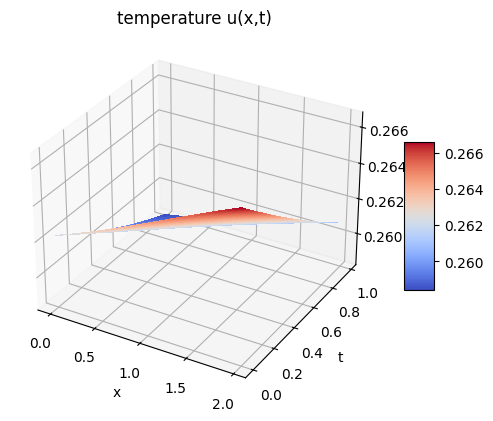

1 Traning Loss: tensor(0.3511, device='cuda:0')


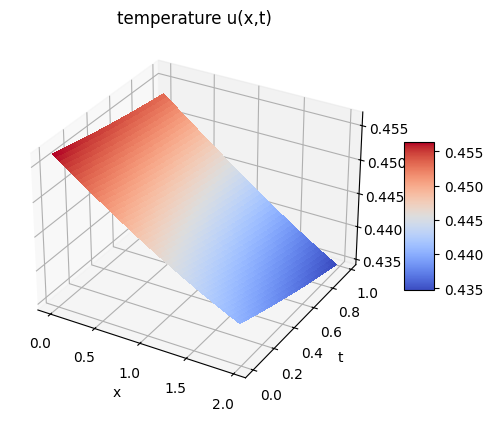

2 Traning Loss: tensor(0.4106, device='cuda:0')


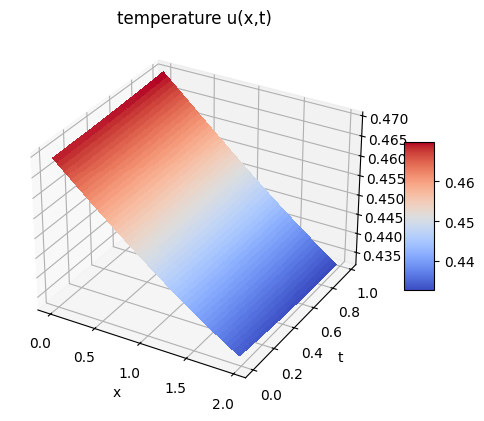

3 Traning Loss: tensor(0.4120, device='cuda:0')


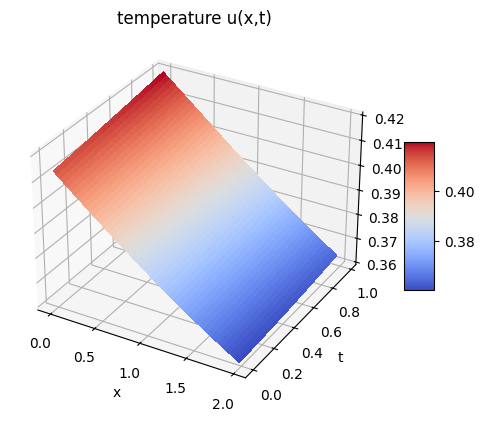

4 Traning Loss: tensor(0.3782, device='cuda:0')


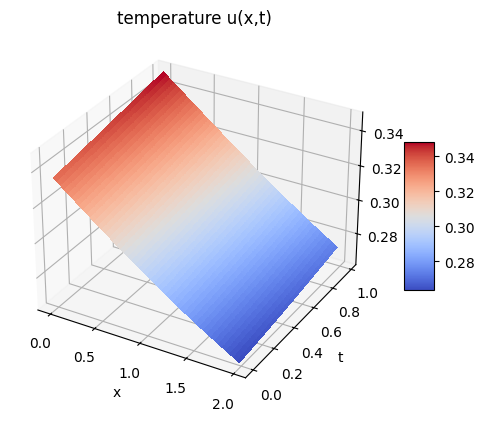

5 Traning Loss: tensor(0.3014, device='cuda:0')


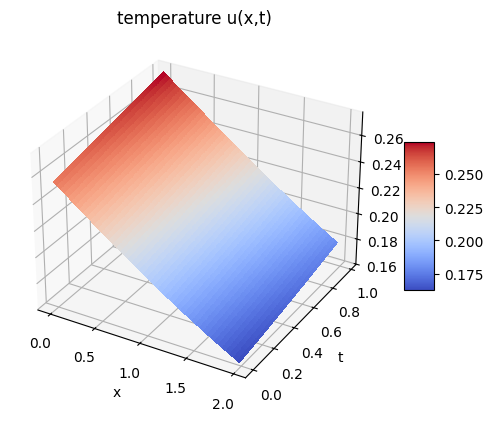

6 Traning Loss: tensor(0.2555, device='cuda:0')


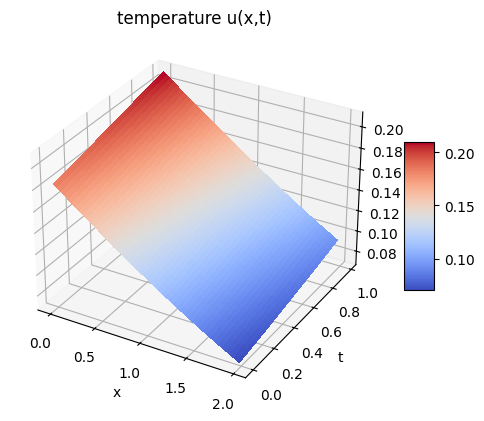

7 Traning Loss: tensor(0.2958, device='cuda:0')


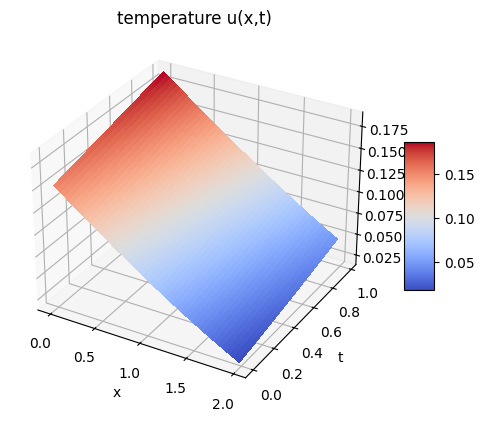

8 Traning Loss: tensor(0.2831, device='cuda:0')


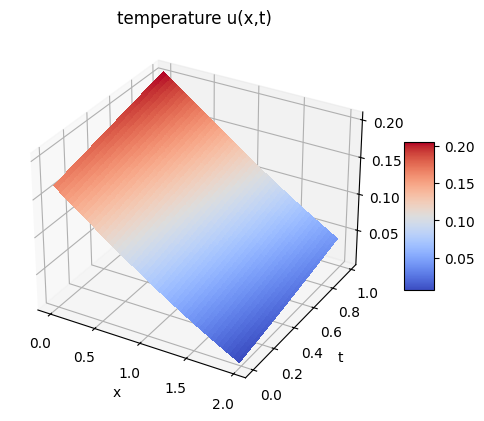

9 Traning Loss: tensor(0.3810, device='cuda:0')


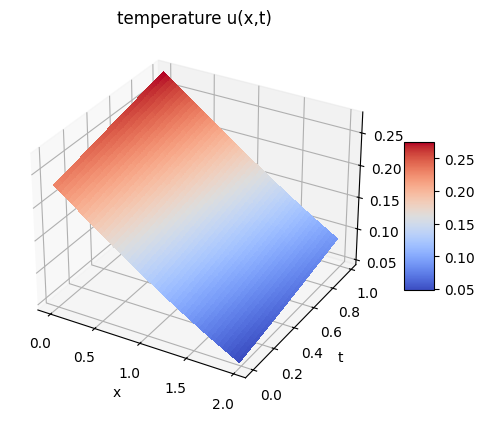

10 Traning Loss: tensor(0.3749, device='cuda:0')


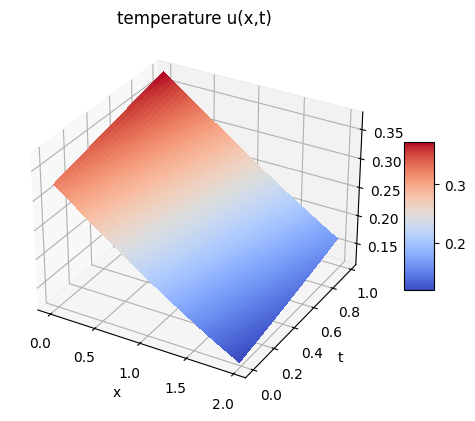

25 Traning Loss: tensor(0.1179, device='cuda:0')


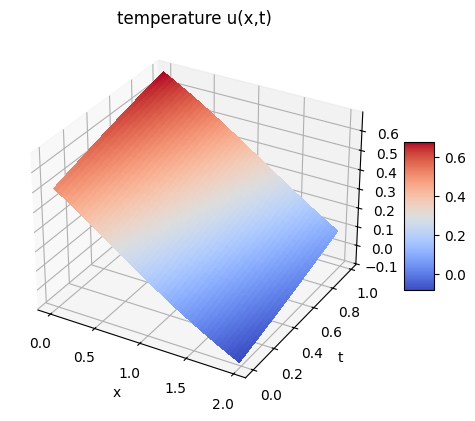

50 Traning Loss: tensor(0.0990, device='cuda:0')


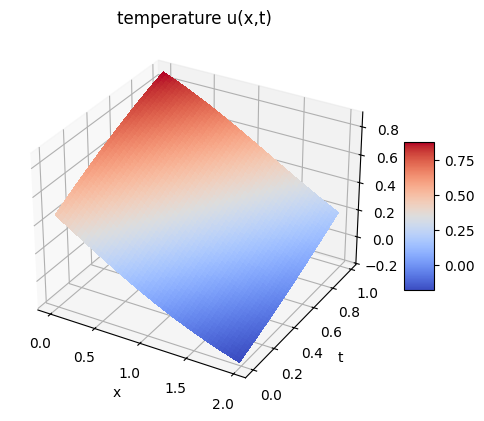

100 Traning Loss: tensor(0.0679, device='cuda:0')


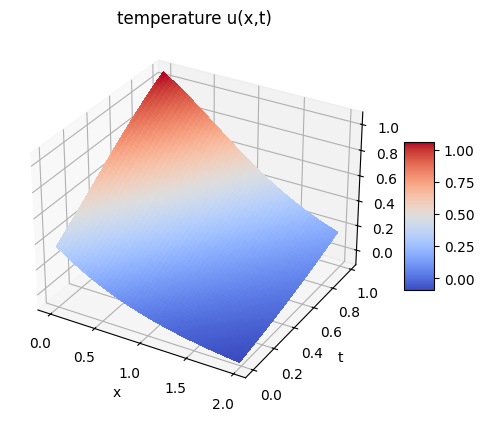

200 Traning Loss: tensor(0.0473, device='cuda:0')


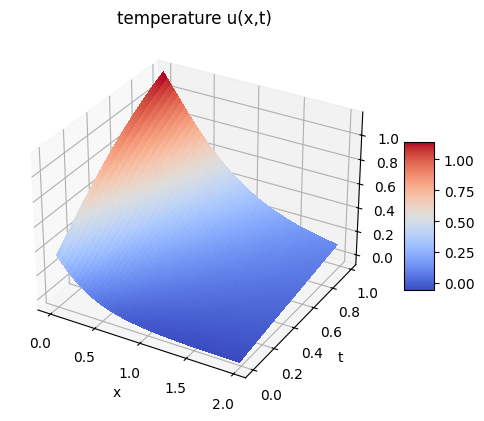

300 Traning Loss: tensor(0.0299, device='cuda:0')
400 Traning Loss: tensor(0.0135, device='cuda:0')
500 Traning Loss: tensor(0.0069, device='cuda:0')


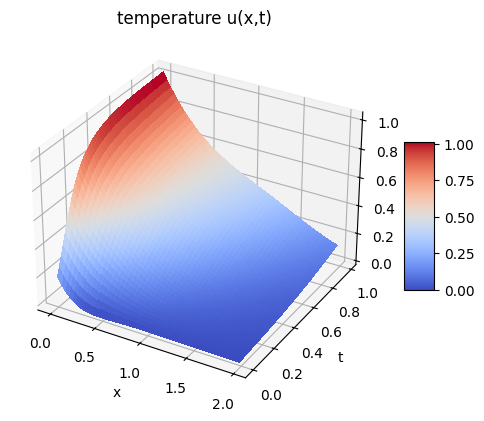

600 Traning Loss: tensor(0.0063, device='cuda:0')
700 Traning Loss: tensor(0.0067, device='cuda:0')
800 Traning Loss: tensor(0.0044, device='cuda:0')
900 Traning Loss: tensor(0.0043, device='cuda:0')
1000 Traning Loss: tensor(0.0030, device='cuda:0')


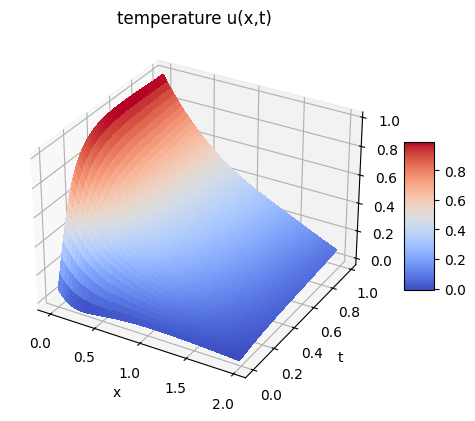

1100 Traning Loss: tensor(0.0029, device='cuda:0')
1200 Traning Loss: tensor(0.0025, device='cuda:0')
1300 Traning Loss: tensor(0.0030, device='cuda:0')
1400 Traning Loss: tensor(0.0019, device='cuda:0')
1500 Traning Loss: tensor(0.0014, device='cuda:0')


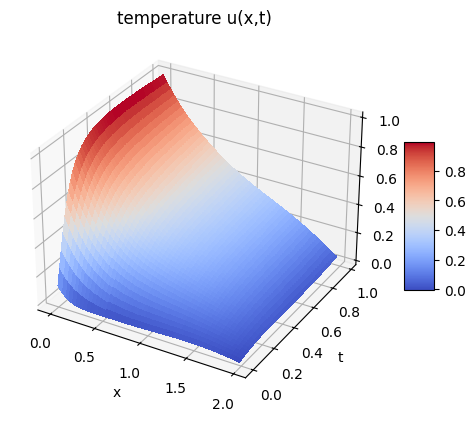

1600 Traning Loss: tensor(0.0011, device='cuda:0')
1700 Traning Loss: tensor(0.0011, device='cuda:0')
1800 Traning Loss: tensor(0.0006, device='cuda:0')
1900 Traning Loss: tensor(0.0004, device='cuda:0')
2000 Traning Loss: tensor(0.0007, device='cuda:0')


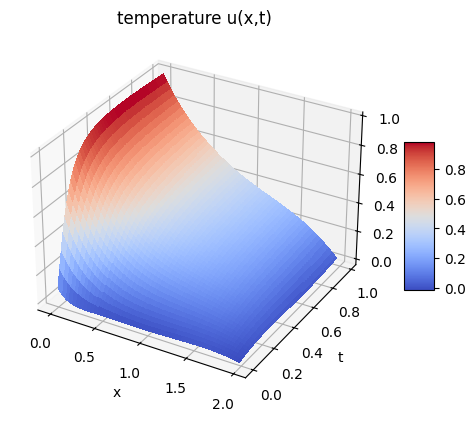

2100 Traning Loss: tensor(0.0008, device='cuda:0')
2200 Traning Loss: tensor(0.0004, device='cuda:0')
2300 Traning Loss: tensor(0.0004, device='cuda:0')
2400 Traning Loss: tensor(0.0004, device='cuda:0')
2500 Traning Loss: tensor(0.0002, device='cuda:0')


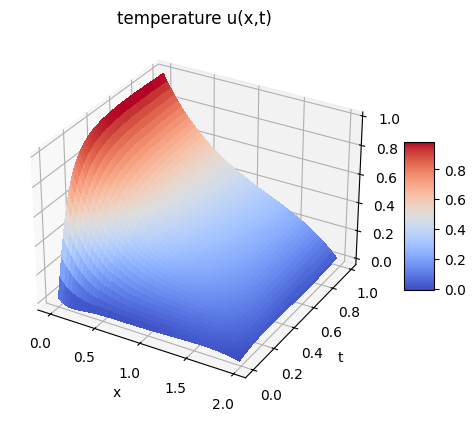

2600 Traning Loss: tensor(0.0002, device='cuda:0')
2700 Traning Loss: tensor(0.0003, device='cuda:0')
2800 Traning Loss: tensor(0.0002, device='cuda:0')
2900 Traning Loss: tensor(0.0001, device='cuda:0')
3000 Traning Loss: tensor(0.0001, device='cuda:0')


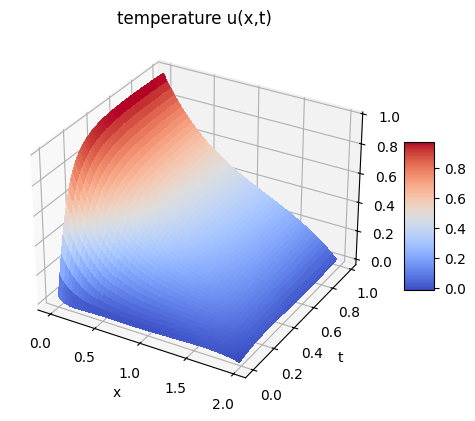

3100 Traning Loss: tensor(0.0001, device='cuda:0')
3200 Traning Loss: tensor(0.0002, device='cuda:0')
3300 Traning Loss: tensor(0.0002, device='cuda:0')
3400 Traning Loss: tensor(0.0003, device='cuda:0')
3500 Traning Loss: tensor(0.0002, device='cuda:0')


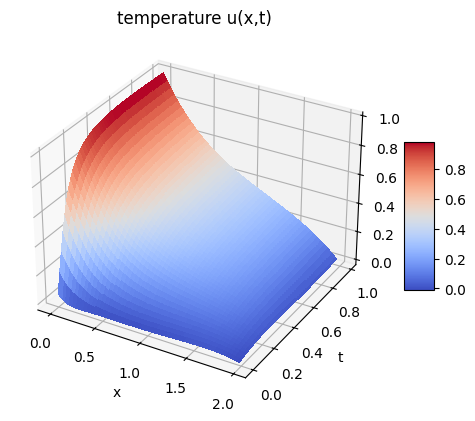

3600 Traning Loss: tensor(0.0006, device='cuda:0')
3700 Traning Loss: tensor(0.0003, device='cuda:0')
3800 Traning Loss: tensor(0.0002, device='cuda:0')
3900 Traning Loss: tensor(0.0002, device='cuda:0')
4000 Traning Loss: tensor(0.0002, device='cuda:0')


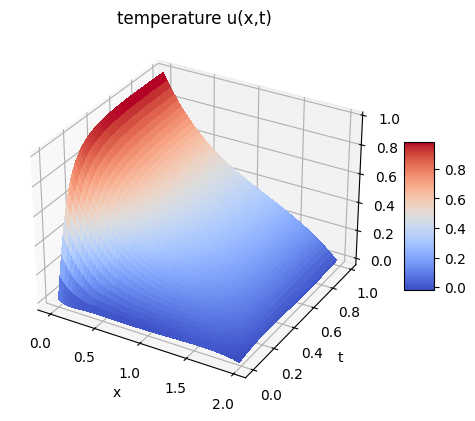

4100 Traning Loss: tensor(0.0001, device='cuda:0')
4200 Traning Loss: tensor(0.0003, device='cuda:0')
4300 Traning Loss: tensor(0.0002, device='cuda:0')
4400 Traning Loss: tensor(0.0004, device='cuda:0')
4500 Traning Loss: tensor(0.0002, device='cuda:0')


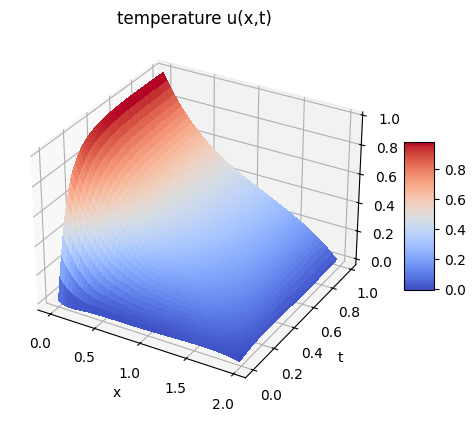

4600 Traning Loss: tensor(0.0002, device='cuda:0')
4700 Traning Loss: tensor(0.0002, device='cuda:0')
4800 Traning Loss: tensor(0.0002, device='cuda:0')
4900 Traning Loss: tensor(0.0002, device='cuda:0')


In [7]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

heat_equation.solve(N_iter=5000)

# Plot results

<IPython.core.display.Javascript object>

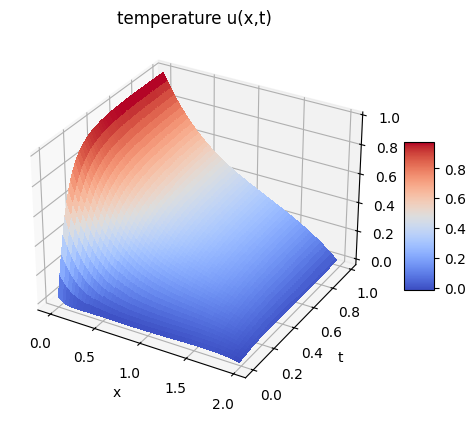

In [8]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

heat_equation.plot_forward()